In [1]:
import pickle
import numpy as np
import pandas as pd
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
#Importing Data set
data_path = "/Users/dorothyjeyson/Kaggle/Text_classification/Data/"

#Dataframe
with open(data_path+"Preprocessed.pickle", "rb") as data:
    df = pickle.load(data)
    
#Features_Train
with open(data_path+"features_train.pickle", "rb") as data:
    features_train = pickle.load(data)

#Labels_Train
with open(data_path+"labels_train.pickle", "rb") as data:
    labels_train = pickle.load(data)

#Features_Test
with open(data_path+"features_test.pickle", "rb") as data:
    features_test = pickle.load(data)
    
#Labels_Test
with open(data_path+"labels_test.pickle", "rb") as data:
    labels_test = pickle.load(data)

Let's check the dimension of our feature vectors:

In [3]:
print(features_train.shape)
print(features_test.shape)

(1796, 300)
(317, 300)


### Cross Validation for hyperparameter tuning

First, we can see what hyperparameters the model has:

In [4]:
gb_0 = GradientBoostingClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(gb_0.get_params())

Parameters currently in use:

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 8,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

Tree-related hyperparameters:

- n_estimators = number of trees in the forest.
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

Boosting-related hyperparameters:

- learning_rate= learning rate shrinks the contribution of each tree by learning_rate.
- subsample= the fraction of samples to be used for fitting the individual base learners.

### Randomized Search Cross Validation
We first need to define the grid. Since we have a huge amount of hyperparameters, we'll try few values for each one.

In [5]:
# n_estimators
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


In [6]:
# First create the base model to tune
gbc = GradientBoostingClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=gbc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 181.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

We can see the best hyperparameters resulting from the Random Search:

In [7]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'learning_rate': 0.5}

The mean accuracy of a model with these hyperparameters is:
0.6080178173719376


After that, we can do a more exhaustive search centered in those values:

### Grid Search Cross Validation

In [8]:
# Create the parameter grid based on the results of random search 
max_depth = [5, 10, 15]
max_features = ['sqrt']
min_samples_leaf = [2]
min_samples_split = [50, 100]
n_estimators = [800]
learning_rate = [.1, .5]
subsample = [1.]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
gbc = GradientBoostingClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.7min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_sa...
                                                  tol=0.0001,
                                                  validation_fraction=0.1,
                                                  verbose=0, warm_st

The best hyperparameters turn out to be:

In [9]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'learning_rate': 0.5, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 50, 'n_estimators': 800, 'subsample': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.596964586846543


Let's save the model in best_gbc:

In [10]:
best_gbc = grid_search.best_estimator_
best_gbc

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=50,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='auto',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

We now know the best gradient boosting model. Let's fit it and see how it performs:

### Model fit and performance
Now, we can fit the model to our training data:

In [11]:
best_gbc.fit(features_train, labels_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=50,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='auto',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

And get the predictions:

In [12]:
gbc_pred = best_gbc.predict(features_test)

The conditional class probabilities can be obtained by typing:

gbc_pred = best_gbc.predict_proba(features_test)

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

### Training accuracy

In [13]:
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_gbc.predict(features_train)))

The training accuracy is: 
0.6904231625835189


### Testing accuracy

In [14]:
print("The test accuracy is: ")
print(accuracy_score(labels_test, gbc_pred))

The test accuracy is: 
0.19558359621451105


### Classification Report

In [15]:
print("Classification report")
print(classification_report(labels_test,gbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.26      0.32      0.28        76
           1       0.18      0.16      0.17        49
           2       0.17      0.14      0.16        64
           3       0.18      0.16      0.17        67
           4       0.15      0.16      0.16        61

    accuracy                           0.20       317
   macro avg       0.19      0.19      0.19       317
weighted avg       0.19      0.20      0.19       317



### Confusion Matrix

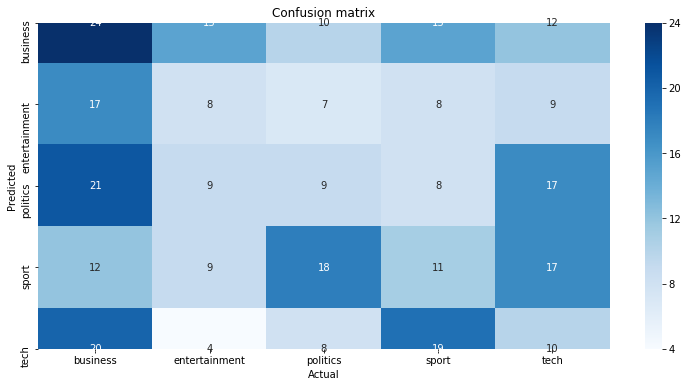

In [16]:
aux_df = df[['Category', 'CategoryCode']].drop_duplicates().sort_values('CategoryCode')
conf_matrix = confusion_matrix(labels_test, gbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

features_time = features_train

elapsed_list = []

for i in range(0,10):

    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)

Let's see if the hyperparameter tuning process has returned a better model:

In [17]:
base_model = GradientBoostingClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.17350157728706625

In [18]:
best_gbc.fit(features_train, labels_train)
accuracy_score(labels_test, best_gbc.predict(features_test))

0.19558359621451105

We'll create a dataset with a model summary to compare models:

In [19]:
d = {
     'Model': 'Gradient Boosting',
     'Training Set Accuracy': accuracy_score(labels_train, best_gbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, gbc_pred)
}

df_models_gbc = pd.DataFrame(d, index=[0])
df_models_gbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Gradient Boosting,0.690423,0.195584


Let's save the model and this dataset:

In [20]:
with open('Models/best_gbc.pickle', 'wb') as output:
    pickle.dump(best_gbc, output)
    
with open('Models/df_models_gbc.pickle', 'wb') as output:
    pickle.dump(df_models_gbc, output)